### Based on kernel regression ( Gaussian kernel smoothing to estimate the preprocessing function )
a more refined and robust approximation

Estimating G(y) using kernel regression: 100%|█| 5000/5000 [00:41<00:00, 120.83i


Subspace alignment (mean singular value): 0.0212


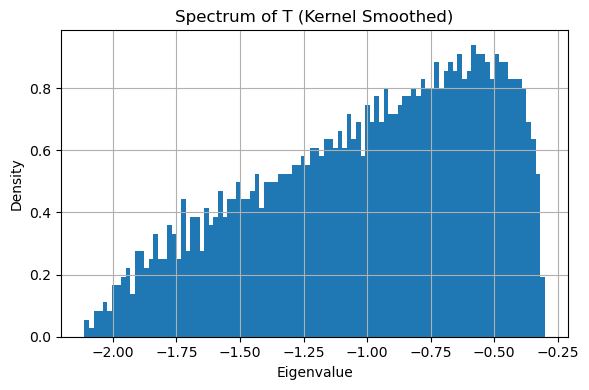

In [ ]:
import numpy as np
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from tqdm import tqdm

# Gaussian kernel function
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

# Kernel regression to estimate E[zzᵀ | y] - I
def estimate_G_list_kernel(Z, y, bandwidth):
    n, p = Z.shape
    G_list = []

    for i in tqdm(range(n), desc="Estimating G(y) via kernel regression"):
        # Compute kernel weights
        weights = gaussian_kernel((y[i] - y) / bandwidth)
        weights /= np.sum(weights)

        # Weighted covariance estimate
        weighted_cov = np.zeros((p, p))
        for j in range(n):
            zzT = np.outer(Z[j], Z[j])
            weighted_cov += weights[j] * zzT

        # G(y) = E[zzᵀ | y] - I
        G_i = weighted_cov - np.eye(p)
        G_list.append(G_i)
    
    return G_list  # List of (p × p) matrices

# Build the symmetric spectral matrix T ∈ ℝ^{dp × dp}
def build_symmetric_T(X, G_list):
    n, d = X.shape
    p = G_list[0].shape[0]
    T = np.zeros((d * p, d * p))

    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        G_y = G_list[i]
        # Preprocessing: T(y) = G(G + I)⁻¹
        T_y = G_y @ np.linalg.inv(G_y + np.eye(p))

        # Assemble block structure for T
        for mu in range(p):
            for nu in range(p):
                T_block = T_y[mu, nu] * (xi @ xi.T)  # d × d block
                row_start = mu * d
                col_start = nu * d
                T[row_start:row_start+d, col_start:col_start+d] += T_block

    T /= n
    return T

def main():
    # Parameter setup
    n = 5000          # Number of samples
    d = 1000          # Input dimension
    p = 2             # Subspace dimension (index)
    alpha = n / d     # Sampling ratio
    bandwidth = 0.1   # Kernel smoothing bandwidth
    np.random.seed(42)

    # Generate true signal subspace W*
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)

    # Generate samples
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star                # Shape: (n, p)
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2                   # Nonlinear response

    # Estimate G(y) = E[zzᵀ | y] - I via kernel regression
    G_list = estimate_G_list_kernel(Z, y, bandwidth=bandwidth)

    # Construct the symmetric spectral matrix T
    T = build_symmetric_T(X, G_list)

    # Compute leading eigenvalue and eigenvector
    eigval, eigvec = eigsh(T, k=1, which='LM')
    w_hat = eigvec[:, 0]
    W_hat = w_hat.reshape(d, p)
    W_hat /= np.linalg.norm(W_hat, axis=0)

    # Subspace alignment score
    overlap = W_hat.T @ W_star
    u, s, _ = np.linalg.svd(overlap)
    alignment = np.mean(s)
    print(f"Subspace alignment (mean singular value): {alignment:.4f}")

    # Visualize spectral distribution
    plt.figure(figsize=(6, 4))
    plt.title("Spectrum of T (Kernel Smoothed)")
    plt.hist(np.linalg.eigvalsh(T), bins=100, density=True)
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Running with α = n/d = 10.00, p = 2, bandwidth = 0.1


Estimating G(y) using kernel regression: 100%|█| 10000/10000 [02:34<00:00, 64.80


Subspace alignment score (mean singular value): 0.0425


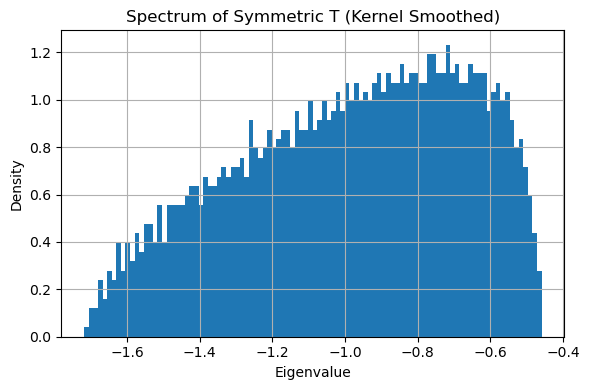

In [ ]:
import numpy as np
from scipy.linalg import eigh, qr
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from tqdm import tqdm

# Gaussian kernel function
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

# Subspace alignment score based on principal angles
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Kernel regression to estimate G(y) = E[zzᵀ | y] − I
def estimate_G_list_kernel(Z, y, bandwidth):
    n, p = Z.shape
    G_list = []

    for i in tqdm(range(n), desc="Estimating G(y) via kernel regression"):
        # Compute kernel weights
        weights = gaussian_kernel((y[i] - y) / bandwidth)
        weights /= np.sum(weights)

        # Weighted covariance estimate
        weighted_cov = np.zeros((p, p))
        for j in range(n):
            zzT = np.outer(Z[j], Z[j])
            weighted_cov += weights[j] * zzT

        # G(y) = E[zzᵀ | y] − I
        G_i = weighted_cov - np.eye(p)
        G_list.append(G_i)
    
    return G_list  # List of (p × p) matrices

# Construct symmetric spectral matrix T ∈ ℝ^{dp × dp}
def build_symmetric_T(X, G_list):
    n, d = X.shape
    p = G_list[0].shape[0]
    T = np.zeros((d * p, d * p))

    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        G_y = G_list[i]
        # Preprocessing: T(y) = G(G + I)⁻¹
        T_y = G_y @ np.linalg.inv(G_y + np.eye(p))

        # Assemble block structure
        for mu in range(p):
            for nu in range(p):
                T_block = T_y[mu, nu] * (xi @ xi.T)  # d × d block
                row_start = mu * d
                col_start = nu * d
                T[row_start:row_start+d, col_start:col_start+d] += T_block

    T /= n
    return T

def main(n=10000, d=1000, p=2, bandwidth=0.1, seed=42):
    np.random.seed(seed)
    alpha = n / d
    print(f"Running with α = n/d = {alpha:.2f}, p = {p}, bandwidth = {bandwidth}")

    # Generate true signal subspace W*
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)

    # Generate input samples and nonlinear responses
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star               # Shape: (n, p)
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2                  # Nonlinear response

    # Estimate G(y) via kernel regression
    G_list = estimate_G_list_kernel(Z, y, bandwidth=bandwidth)

    # Construct symmetric spectral matrix T
    T = build_symmetric_T(X, G_list)

    # Extract top-p eigenvectors associated with largest eigenvalues
    eigvals, eigvecs = eigsh(T, k=p, which='LM')
    W_hat = np.stack([eigvecs[i*d:(i+1)*d, i] for i in range(p)], axis=1)
    W_hat /= np.linalg.norm(W_hat, axis=0)

    # Compute subspace alignment score
    score = alignment_score(W_hat, W_star)
    print(f"Subspace alignment score (mean singular value): {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.title("Spectrum of Symmetric T (Kernel Smoothed)")
    plt.hist(np.linalg.eigvalsh(T), bins=100, density=True)
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Kernel regression E[zz^T|y]: 100%|████████████████| 5/5 [00:00<00:00, 23.07it/s]


[Kernel-SSE] n=5000, d=100, p=2
Alignment (mean singular value): 0.9821
Top eigenvalues: [-0.80800208 -0.80008284]


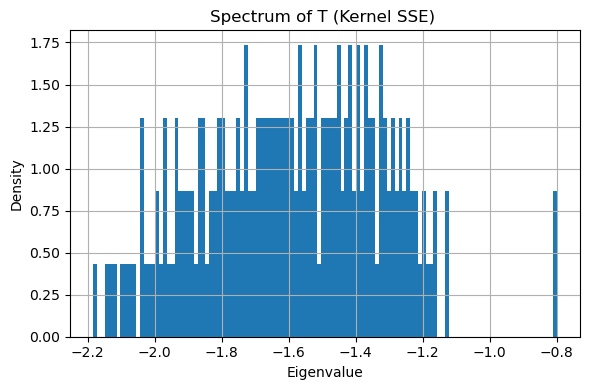

In [ ]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.linalg import qr
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------------------------
# Utility functions
# ---------------------------------
def zscore(x, eps=1e-12):
    x = np.asarray(x)
    mu, sd = x.mean(), x.std()
    sd = max(sd, eps)
    return (x - mu) / sd

def silverman_bandwidth(y):
    # Silverman's rule-of-thumb for 1D kernel regression bandwidth
    y = np.asarray(y)
    n = len(y)
    sigma = np.std(y)
    return 1.06 * sigma * n ** (-1/5)

def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

# ---------------------------------
# 1) Kernel regression to estimate E[zzᵀ | y] 
#    Only three degrees of freedom: (t11, t12, t22)
#    Vectorized + chunking to avoid O(n²) memory usage
# ---------------------------------
def estimate_second_moment_kernel(Z, y, bandwidth=None, chunk=1024):
    """
    Returns Sigma_y: shape (n, 2, 2), where Sigma_y[i] ≈ E[zzᵀ | y = y_i]
    """
    n, p = Z.shape
    assert p == 2, "Current implementation assumes p=2"
    y = np.asarray(y).reshape(-1)
    if bandwidth is None:
        bandwidth = silverman_bandwidth(y)
        bandwidth = max(bandwidth, 1e-3)

    # Precompute three degrees of freedom: V = [t11, t12, t22]
    t11 = Z[:, 0] * Z[:, 0]
    t12 = Z[:, 0] * Z[:, 1]
    t22 = Z[:, 1] * Z[:, 1]
    V = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    Sigma_y = np.zeros((n, 2, 2), dtype=np.float64)

    # Chunked kernel regression: process subsets of i against all j
    for start in tqdm(range(0, n, chunk), desc="Kernel regression E[zzᵀ|y]"):
        end = min(start + chunk, n)
        yi = y[start:end]                          # (m,)
        # Kernel weights K_ij = K((yi - yj)/h), shape (m, n)
        U = (yi[:, None] - y[None, :]) / bandwidth
        W = gaussian_kernel(U)
        # Normalize weights
        W_sum = W.sum(axis=1, keepdims=True) + 1e-12
        W /= W_sum
        # Nadaraya-Watson regression: (m,n) @ (n,3) → (m,3)
        M = W @ V
        # Restore symmetric 2×2 covariance structure
        Sigma_y[start:end, 0, 0] = M[:, 0]
        Sigma_y[start:end, 0, 1] = M[:, 1]
        Sigma_y[start:end, 1, 0] = M[:, 1]
        Sigma_y[start:end, 1, 1] = M[:, 2]

    return Sigma_y

# ---------------------------------
# 2) Convert Sigma(y) to T(y) = G(G + I)⁻¹ 
#    Using ridge regularization and solve for stability
# ---------------------------------
def sigma_to_Ty(Sigma_y, ridge_eps=1e-3):
    n = Sigma_y.shape[0]
    I2 = np.eye(2)
    T_y = np.zeros_like(Sigma_y)
    for i in range(n):
        G = Sigma_y[i] - I2
        T_y[i] = G @ np.linalg.solve(G + (1.0 + ridge_eps) * I2, I2)
    return T_y

# ---------------------------------
# 3) Construct symmetric spectral matrix T ∈ ℝ^{(dp)×(dp)}
#    T_(μ,ν) = Xᵀ diag( T_y[:,μ,ν] ) X
# ---------------------------------
def build_T_blocks(X, T_y):
    n, d = X.shape
    p = T_y.shape[1]
    blocks = [[None] * p for _ in range(p)]
    for mu in range(p):
        for nu in range(p):
            w = T_y[:, mu, nu]            # (n,)
            # Xᵀ (w * X)
            blocks[mu][nu] = X.T @ (w[:, None] * X)
    T = np.block(blocks) / n
    # Numerical symmetrization to avoid accumulation errors
    T = 0.5 * (T + T.T)
    return T

# ---------------------------------
# 4) Main workflow
# ---------------------------------
def main():
    # Parameters
    n = 5000
    d = 100        # For kernel regression + block construction, start with smaller d (e.g., 200–400); d=1000 is expensive
    p = 2
    np.random.seed(42)

    # Generate ground-truth signal subspace W*
    W_star = np.random.randn(d, p)
    W_star, _ = qr(W_star, mode='economic')  # Orthonormal columns

    # Generate data
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]                    # Nonlinear response

    # Standardize y and adapt bandwidth
    y_std = zscore(y)
    h = silverman_bandwidth(y_std)

    # Estimate Sigma(y) ≈ E[zzᵀ | y] via kernel regression (vectorized + chunked)
    Sigma_y = estimate_second_moment_kernel(Z, y_std, bandwidth=h, chunk=1024)

    # Compute T(y) with ridge-regularized inversion
    T_y = sigma_to_Ty(Sigma_y, ridge_eps=1e-3)

    # Construct symmetric spectral matrix T
    T = build_T_blocks(X, T_y)

    # Extract top-p eigenvectors (symmetric matrix, use which='LA')
    eigvals, eigvecs = eigsh(T, k=p, which='LA')
    # Sort eigenpairs by eigenvalue magnitude
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Extract corresponding d×p sub-block and orthonormalize
    W_hat = eigvecs[:d, :]
    U, _, Vt = np.linalg.svd(W_hat, full_matrices=False)
    W_hat = U @ Vt

    # Subspace alignment score
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    S = np.linalg.svd(Q1.T @ Q2, compute_uv=False)
    alignment = S.mean()

    print(f"[Kernel-SSE] n={n}, d={d}, p={p}")
    print(f"Alignment (mean singular value): {alignment:.4f}")
    print(f"Top eigenvalues: {eigvals[-p:]}")

    # Visualize spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(np.linalg.eigvalsh(T), bins=120, density=True)
    plt.title(f"Spectrum of T (Kernel SSE)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
